In [1]:
!pip install pmdarima

[*********************100%***********************]  1 of 1 completed


S&P 500 Dataset:
Price             Close         High          Low         Open      Volume
Ticker            ^GSPC        ^GSPC        ^GSPC        ^GSPC       ^GSPC
Date                                                                      
2013-01-02  1462.420044  1462.430054  1426.189941  1426.189941  4202600000
2013-01-03  1459.369995  1465.469971  1455.530029  1462.420044  3829730000
2013-01-04  1466.469971  1467.939941  1458.989990  1459.369995  3424290000
2013-01-07  1461.890015  1466.469971  1456.619995  1466.469971  3304970000
2013-01-08  1457.150024  1461.890015  1451.640015  1461.890015  3601600000

Dataset information:
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2518 entries, 2013-01-02 to 2022-12-30
Data columns (total 5 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   (Close, ^GSPC)   2518 non-null   float64
 1   (High, ^GSPC)    2518 non-null   float64
 2   (Low, ^GSPC)     2518 non-null   float64
 3   (O

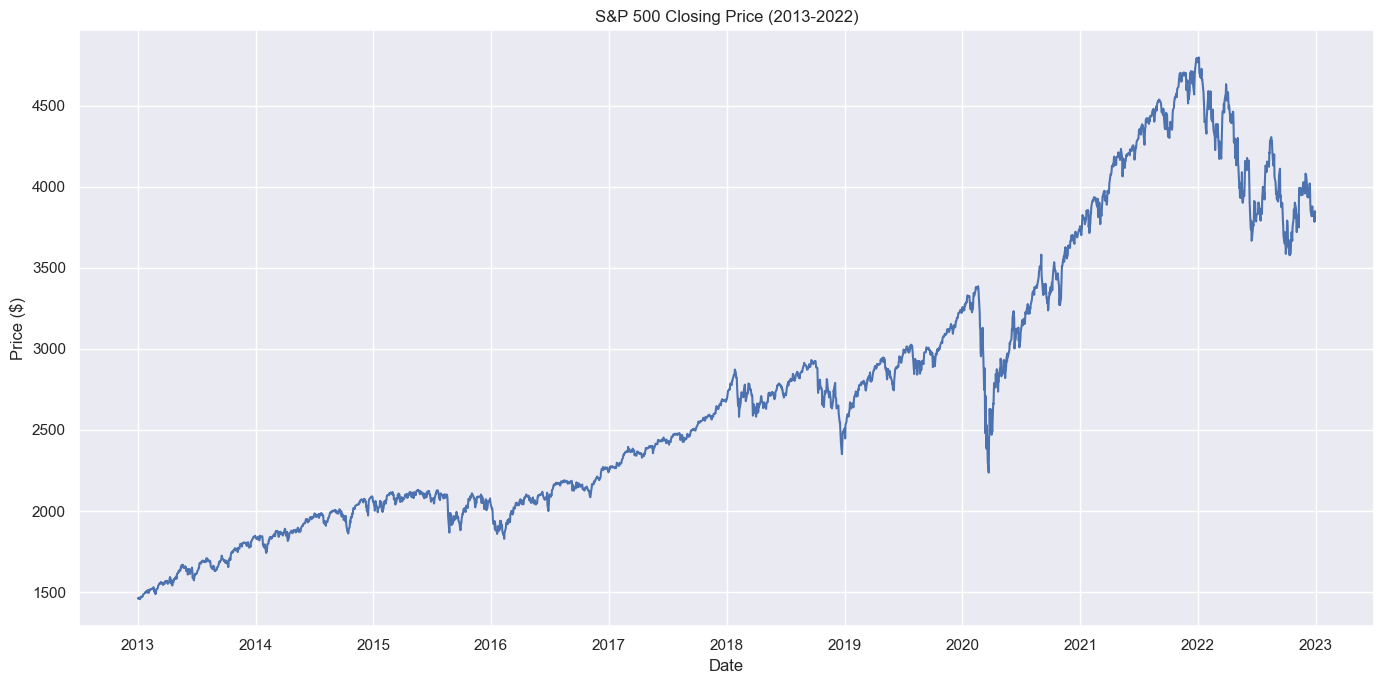


Selected time series shape: (2518, 1)


In [2]:
# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
import yfinance as yf
import warnings
from sklearn.metrics import mean_absolute_error, mean_squared_error
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import acf, pacf
import pmdarima as pm

# Suppress warnings for cleaner output
warnings.filterwarnings('ignore')


# Set plotting style
sns.set_theme()


# Download S&P 500 data for the last 10 years
sp500 = yf.download('^GSPC', start='2013-01-01', end='2022-12-31')


# Display the first few rows of the dataset
print("S&P 500 Dataset:")
print(sp500.head())


# Display basic information about the dataset
print("\nDataset information:")
print(sp500.info())


# Calculate basic summary statistics
print("\nSummary Statistics:")
print(sp500['Close'].describe())


# Check for missing values
print("\nMissing values in each column:")
print(sp500.isnull().sum())


# Plot the closing price
plt.figure(figsize=(14, 7))
plt.plot(sp500.index, sp500['Close'])
plt.title('S&P 500 Closing Price (2013-2022)')
plt.xlabel('Date')
plt.ylabel('Price ($)')
plt.grid(True)
plt.tight_layout()
plt.show()


# Select the closing price as our primary time series for analysis
ts_data = sp500['Close']
print("\nSelected time series shape:", ts_data.shape)

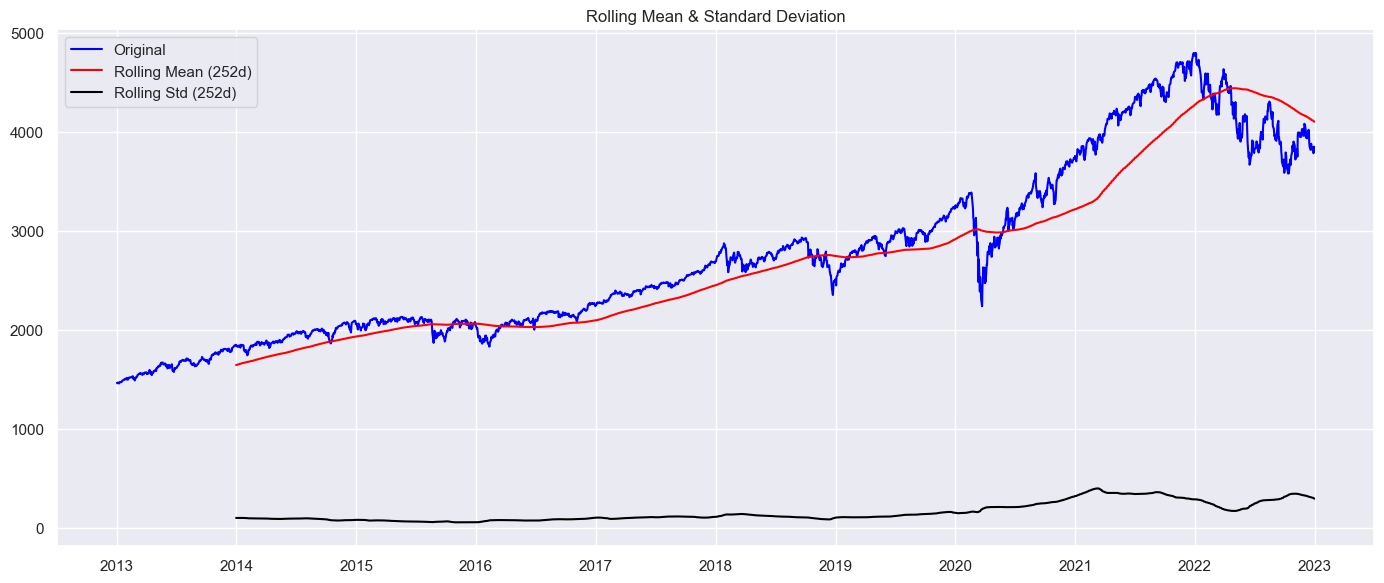

In [3]:
# Calculate rolling mean and std with a 12-month window (252 trading days ≈ 1 year)
rolmean = ts_data.rolling(window=252).mean()
rolstd = ts_data.rolling(window=252).std()

# Plot rolling statistics
plt.figure(figsize=(14, 6))
plt.plot(ts_data, color='blue', label='Original')
plt.plot(rolmean, color='red', label='Rolling Mean (252d)')
plt.plot(rolstd, color='black', label='Rolling Std (252d)')
plt.legend(loc='best')
plt.title('Rolling Mean & Standard Deviation')
plt.grid(True)
plt.tight_layout()
plt.show()


Mean is clearly rising and not stationary

In [4]:
def adf_test(series, title=''):
    print(f'Augmented Dickey-Fuller Test: {title}')
    result = adfuller(series.dropna(), autolag='AIC')
    labels = ['ADF Statistic', 'p-value', '# Lags Used', '# Observations']
    for value, label in zip(result[:4], labels):
        print(f'{label} : {value:.4f}')
    if result[1] <= 0.05:
        print("The series is stationary.")
    else:
        print("The series is non-stationary.")

# Apply ADF test on original data
adf_test(ts_data, 'S&P 500 Closing Price')

Augmented Dickey-Fuller Test: S&P 500 Closing Price
ADF Statistic : -1.0312
p-value : 0.7417
# Lags Used : 10.0000
# Observations : 2507.0000
The series is non-stationary.


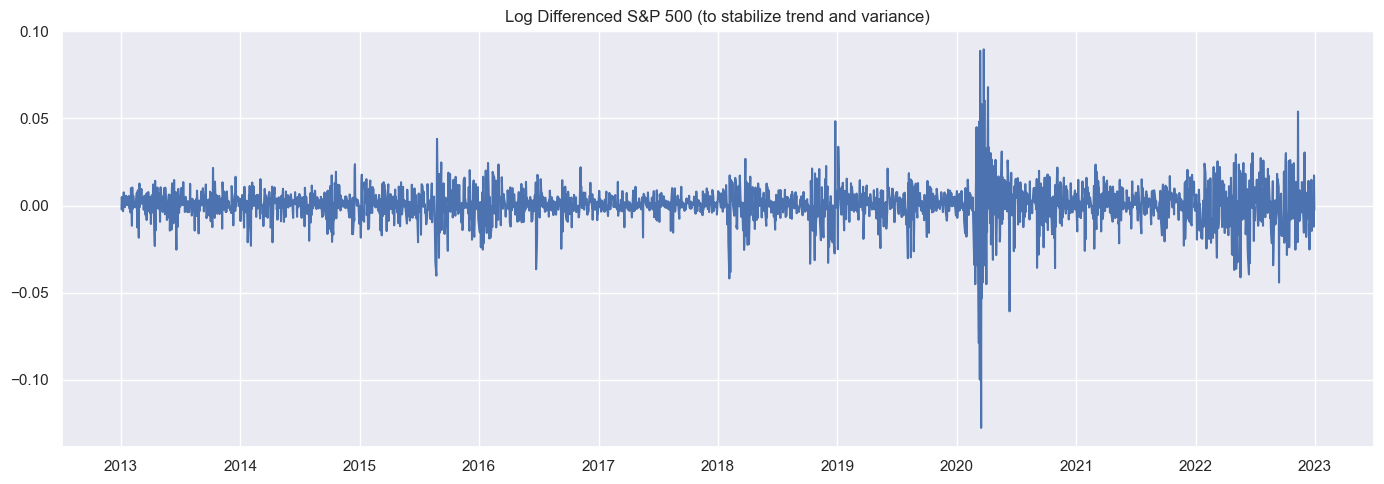

Augmented Dickey-Fuller Test: Log Differenced S&P 500
ADF Statistic : -15.8374
p-value : 0.0000
# Lags Used : 9.0000
# Observations : 2507.0000
The series is stationary.


In [5]:
# Apply log transformation
ts_log = np.log(ts_data)

# Apply first-order differencing to log-transformed data
ts_log_diff = ts_log.diff().dropna()

# Plot the differenced series
plt.figure(figsize=(14, 5))
plt.plot(ts_log_diff)
plt.title('Log Differenced S&P 500 (to stabilize trend and variance)')
plt.grid(True)
plt.tight_layout()
plt.show()

# ADF test on transformed series
adf_test(ts_log_diff, 'Log Differenced S&P 500')

The log-differenced S&P 500 series is stationary, which means it's suitable for modeling with ARIMA.

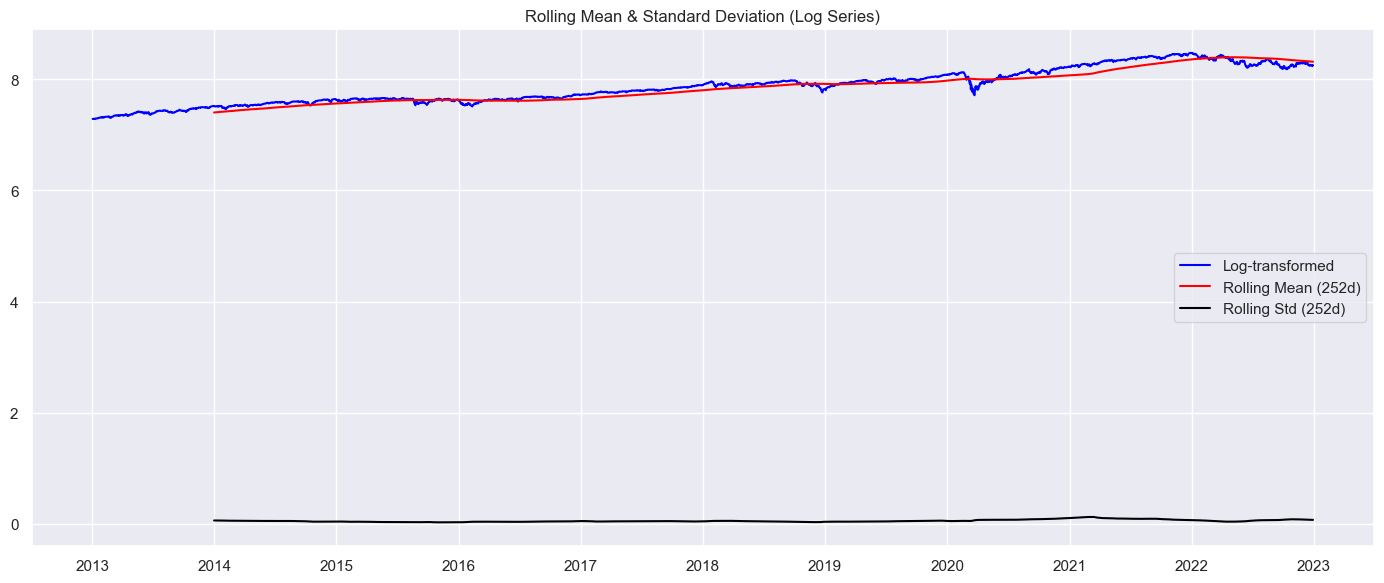

In [6]:
rolmean_log = ts_log.rolling(window=252).mean()
rolstd_log = ts_log.rolling(window=252).std()

plt.figure(figsize=(14, 6))
plt.plot(ts_log, color='blue', label='Log-transformed')
plt.plot(rolmean_log, color='red', label='Rolling Mean (252d)')
plt.plot(rolstd_log, color='black', label='Rolling Std (252d)')
plt.legend(loc='best')
plt.title('Rolling Mean & Standard Deviation (Log Series)')
plt.grid(True)
plt.tight_layout()
plt.show()

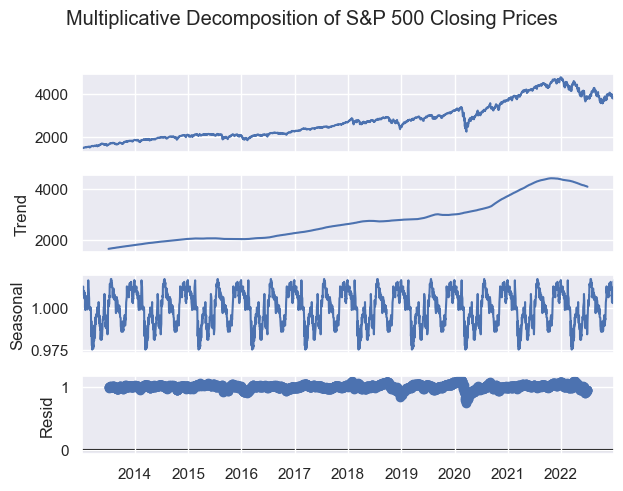

In [7]:
# Drop any missing values just in case
ts_data_clean = ts_data.dropna()

# Decompose with additive model and 252-day cycle (≈1 year of trading days)
decomposition = seasonal_decompose(ts_data_clean, model='multiplicative', period=252)

# Plot the components
decomposition.plot()
plt.suptitle('Multiplicative Decomposition of S&P 500 Closing Prices', y=1.02)
plt.tight_layout()
plt.show()

A repeating, oscillating pattern that appears consistent year over year, suggesting seasonality, but its mild (min of ~.975)

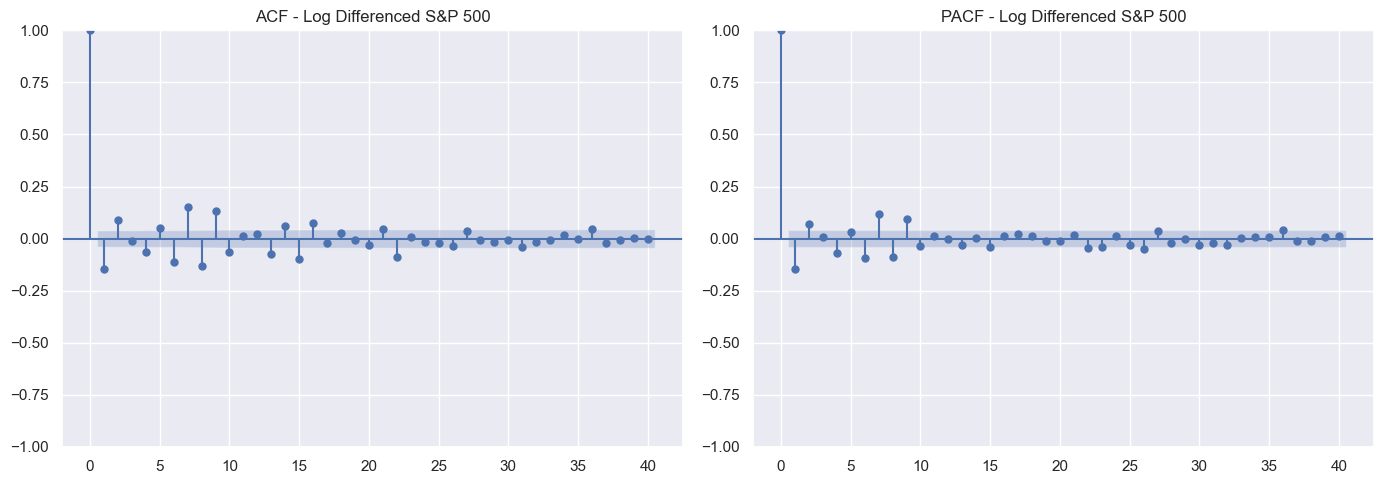

In [8]:
# Plot ACF and PACF
fig, axes = plt.subplots(1, 2, figsize=(14, 5))
plot_acf(ts_log_diff, lags=40, ax=axes[0])
axes[0].set_title('ACF - Log Differenced S&P 500')
plot_pacf(ts_log_diff, lags=40, ax=axes[1])
axes[1].set_title('PACF - Log Differenced S&P 500')
plt.tight_layout()
plt.show()

ACF: Big spikes with no strong cutoff, suggesting a MA component, likely 1.
PACF: Similar, but tapers off quicker, suggesting a AR component, likely 1.
With seasonality, likely need SARIMA

In [9]:
acf_vals = acf(ts_log_diff, nlags=20)
pacf_vals = pacf(ts_log_diff, nlags=20)

print("ACF values for first 20 lags:")
print(acf_vals)

print("\nPACF values for first 20 lags:")
print(pacf_vals)

ACF values for first 20 lags:
[ 1.         -0.14573138  0.08776958 -0.01315881 -0.06222792  0.04893673
 -0.11222234  0.14968382 -0.12939628  0.13093058 -0.06235634  0.0122611
  0.02109069 -0.0742391   0.05936008 -0.09632049  0.07295319 -0.02016876
  0.02788778 -0.00747773 -0.03009081]

PACF values for first 20 lags:
[ 1.00000000e+00 -1.45789303e-01  6.80308163e-02  8.90817760e-03
 -7.07377739e-02  3.22890991e-02 -9.38025915e-02  1.20531705e-01
 -8.86184204e-02  9.52742463e-02 -3.82544873e-02  1.10979433e-02
 -1.40802539e-03 -3.16995172e-02  9.03924522e-04 -3.94802719e-02
  1.46315377e-02  2.37706995e-02  1.03592089e-02 -1.38942396e-02
 -1.35155973e-02]


In [10]:
# Fit SARIMA(1,1,1) on log-transformed original data
seasonal_order = (1, 0, 1, 252)
order = (1, 1, 1)

model = SARIMAX(ts_log, order=order, seasonal_order=seasonal_order, enforce_stationarity=False, enforce_invertibility=False)
model_fit = model.fit()

# Summary
print(model_fit.summary())

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -2.74771D+00    |proj g|=  5.48377D+00

At iterate    5    f= -2.74870D+00    |proj g|=  1.62410D-02

At iterate   10    f= -2.74871D+00    |proj g|=  4.06361D-01

At iterate   15    f= -2.74876D+00    |proj g|=  1.70386D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     16     21      1     0     0   1.267D-02  -2.749D+00
  F =  -2.7487623194169486     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
        

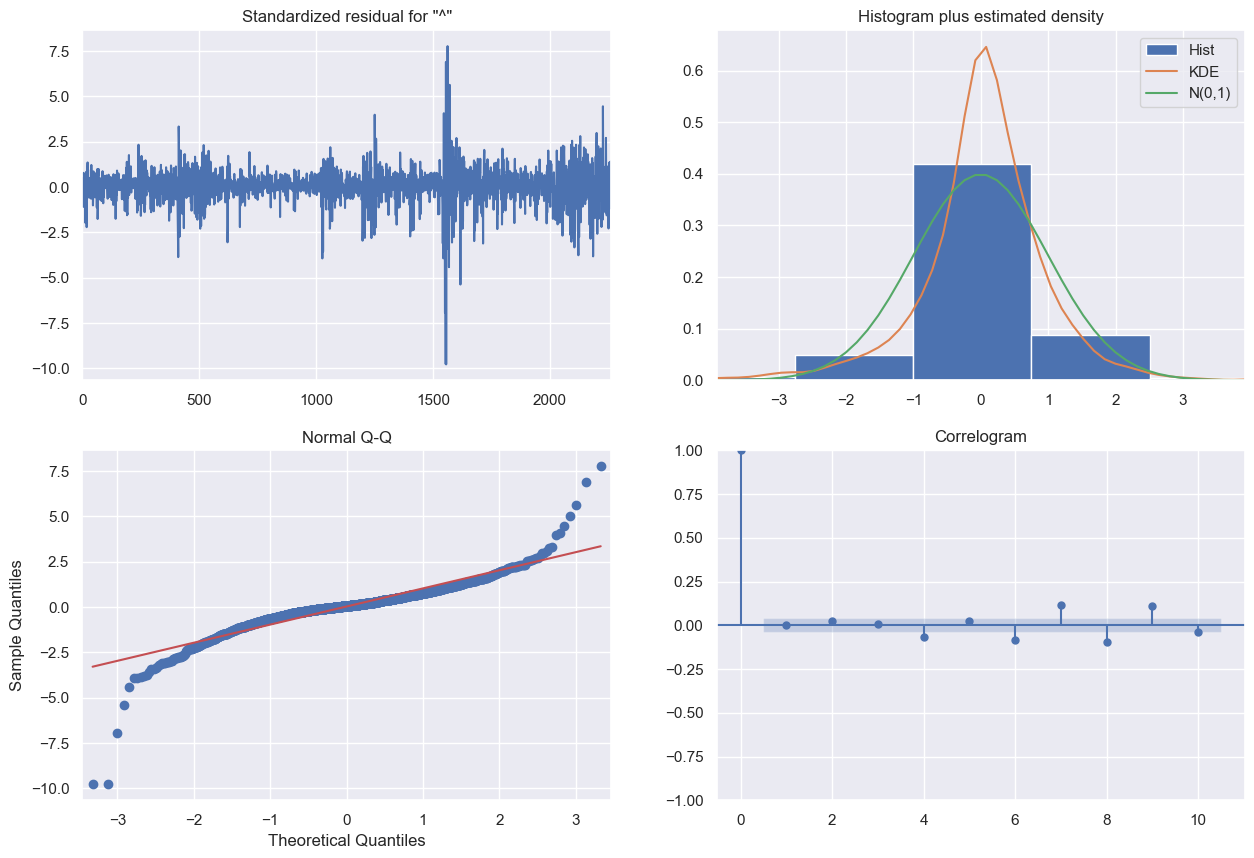

In [11]:
model_fit.plot_diagnostics(figsize=(15, 10))
plt.show()

Seasonality is too weak, try ARIMA with other orders

In [12]:
#Let's try ARIMA with other orders, but keep differencing 1 of course

candidate_orders = [
    (0,1,0),
    (1,1,0),
    (0,1,1),
    (1,1,1),
    (2,1,1),
    (1,1,2),
    (2,1,2),
    (3,1,1),
    (1,1,3)
]

In [13]:
results = []

for order in candidate_orders:
    try:
        model = ARIMA(ts_log, order=order)
        fitted = model.fit()
        results.append({
            'order': order,
            'aic': fitted.aic,
            'bic': fitted.bic,
            'hqic': fitted.hqic,
            'loglikelihood': fitted.llf
        })
    except Exception as e:
        print(f"Order {order} failed to fit: {e}")

In [14]:
df_results = pd.DataFrame(results)
print(df_results.sort_values('aic'))

       order           aic           bic          hqic  loglikelihood
5  (1, 1, 2) -15563.794682 -15540.471390 -15555.330141    7785.897341
8  (1, 1, 3) -15562.532731 -15533.378616 -15551.952055    7786.266365
4  (2, 1, 1) -15561.705568 -15538.382276 -15553.241027    7784.852784
6  (2, 1, 2) -15560.846505 -15531.692390 -15550.265829    7785.423253
7  (3, 1, 1) -15559.991410 -15530.837295 -15549.410734    7784.995705
3  (1, 1, 1) -15557.613405 -15540.120936 -15551.264999    7781.806702
1  (1, 1, 0) -15553.769525 -15542.107879 -15549.537255    7778.884763
2  (0, 1, 1) -15546.598653 -15534.937007 -15542.366382    7775.299326
0  (0, 1, 0) -15502.778444 -15496.947621 -15500.662309    7752.389222


In [15]:
best_model_order = df_results.loc[df_results['aic'].idxmin(), 'order']
print(f"Best model order by AIC: {best_model_order}")

best_model = ARIMA(ts_log, order=best_model_order).fit()
print(best_model.summary())

Best model order by AIC: (1, 1, 2)
                               SARIMAX Results                                
Dep. Variable:                  ^GSPC   No. Observations:                 2518
Model:                 ARIMA(1, 1, 2)   Log Likelihood                7785.897
Date:                Sat, 21 Jun 2025   AIC                         -15563.795
Time:                        13:49:03   BIC                         -15540.471
Sample:                             0   HQIC                        -15555.330
                               - 2518                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1573      0.092     -1.708      0.088      -0.338       0.023
ma.L1          0.0237      0.091      0.259      0.796      -0.155       0.203
ma.L2          0.

Significant improvement with ARIMA(1,1,2) model.

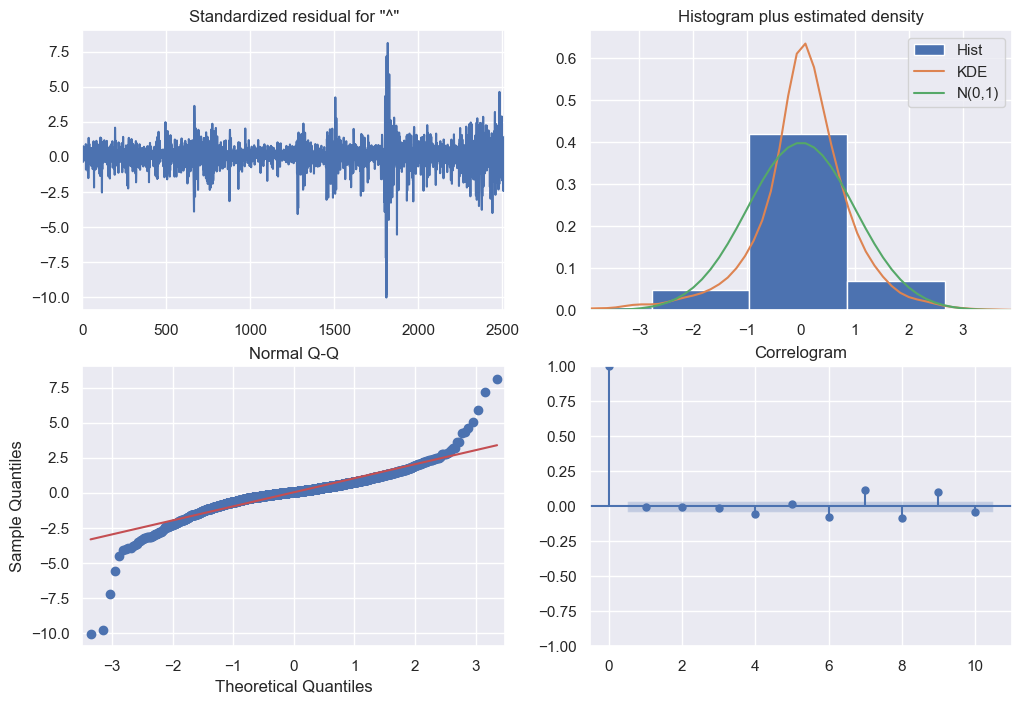

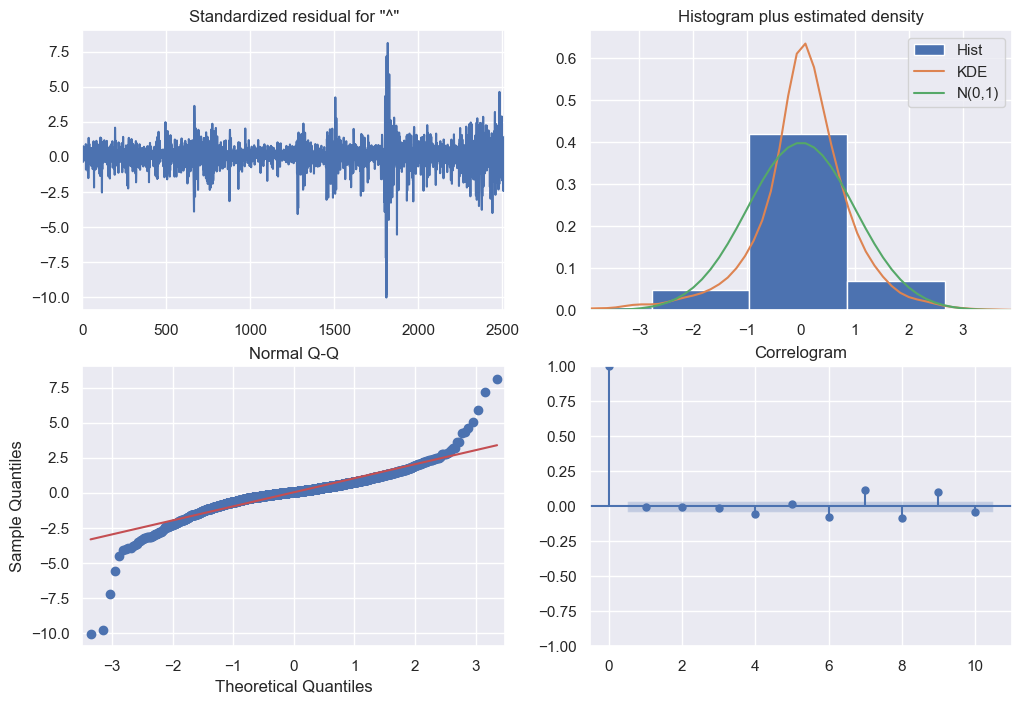

In [16]:
best_model.plot_diagnostics(figsize=(12,8))

In [17]:
x = 252
train = ts_log[:-x]
test = ts_log[-x:]

In [18]:
forecast_result = best_model.get_forecast(steps=x)
forecast_values_log = forecast_result.predicted_mean

forecast_values = np.exp(forecast_values_log)
actual_values = np.exp(test)
actual_values = actual_values.iloc[:, 0]

forecast_values_reset = forecast_values.reset_index()
actual_values_reset = actual_values.reset_index()

results_df = actual_values_reset.join(forecast_values_reset)

results_df.set_index('Date', inplace=True)
results_df.drop(columns = 'index', inplace=True)

In [19]:
def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    mask = y_true != 0
    return np.mean(np.abs((y_true[mask] - y_pred[mask]) / y_true[mask])) * 100

mae = mean_absolute_error(actual_values, forecast_values)
rmse = np.sqrt(mean_squared_error(actual_values, forecast_values))
mape = mean_absolute_percentage_error(actual_values, forecast_values)

print(f"MAE: {mae:.6f}")
print(f"RMSE: {rmse:.6f}")
print(f"MAPE: {mape:.2f}%")

MAE: 300.256776
RMSE: 389.634684
MAPE: 6.97%


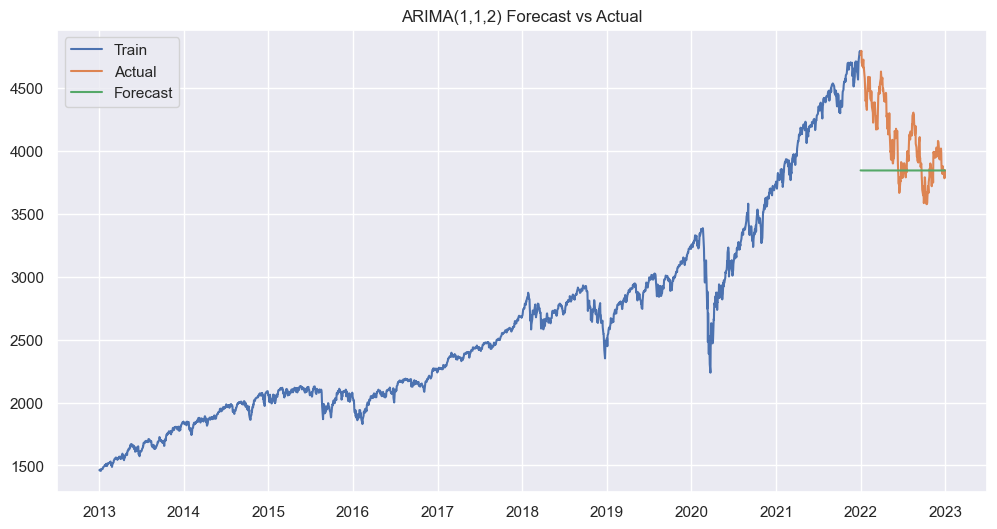

In [20]:
plt.figure(figsize=(12,6))
plt.plot(train.index, np.exp(train), label='Train')
plt.plot(results_df.index, results_df['^GSPC'], label='Actual')
plt.plot(results_df.index, results_df['predicted_mean'], label='Forecast')
plt.legend()
plt.title("ARIMA(1,1,2) Forecast vs Actual")
plt.show()

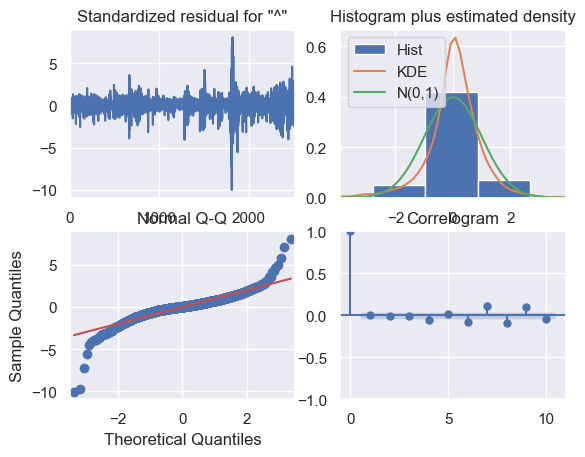

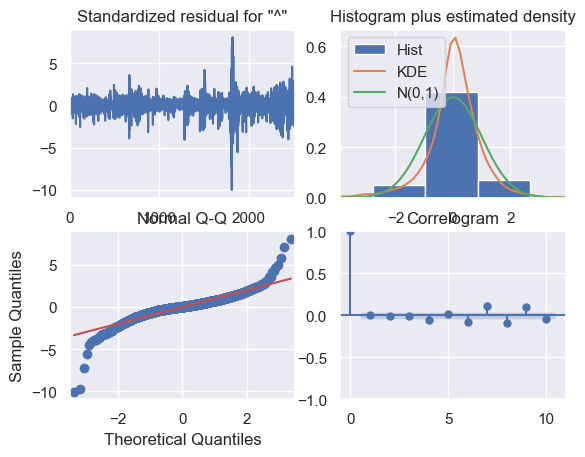

In [21]:
best_model.plot_diagnostics()

<Axes: title={'center': 'Training Data'}, xlabel='Date'>

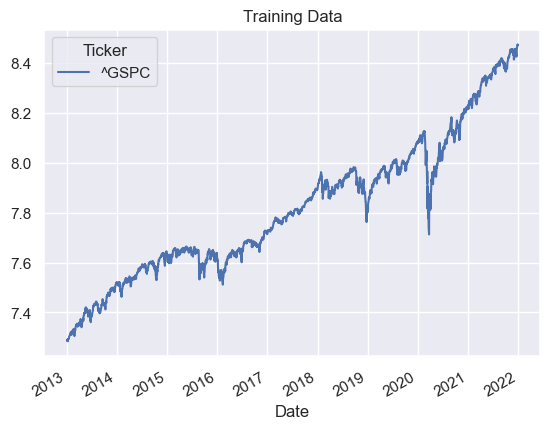

In [22]:
train.plot(title='Training Data')

In [23]:
print(best_model.summary())

                               SARIMAX Results                                
Dep. Variable:                  ^GSPC   No. Observations:                 2518
Model:                 ARIMA(1, 1, 2)   Log Likelihood                7785.897
Date:                Sat, 21 Jun 2025   AIC                         -15563.795
Time:                        13:49:04   BIC                         -15540.471
Sample:                             0   HQIC                        -15555.330
                               - 2518                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1573      0.092     -1.708      0.088      -0.338       0.023
ma.L1          0.0237      0.091      0.259      0.796      -0.155       0.203
ma.L2          0.0761      0.016      4.825      0.0

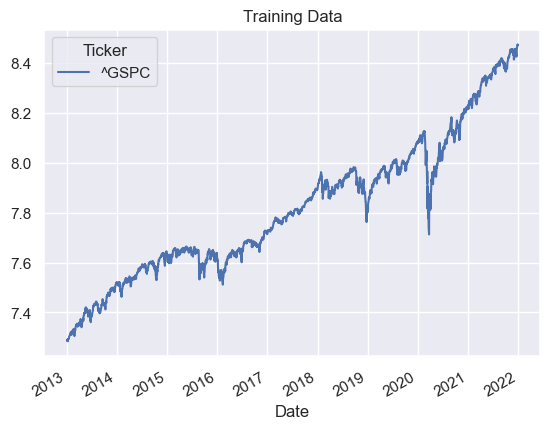

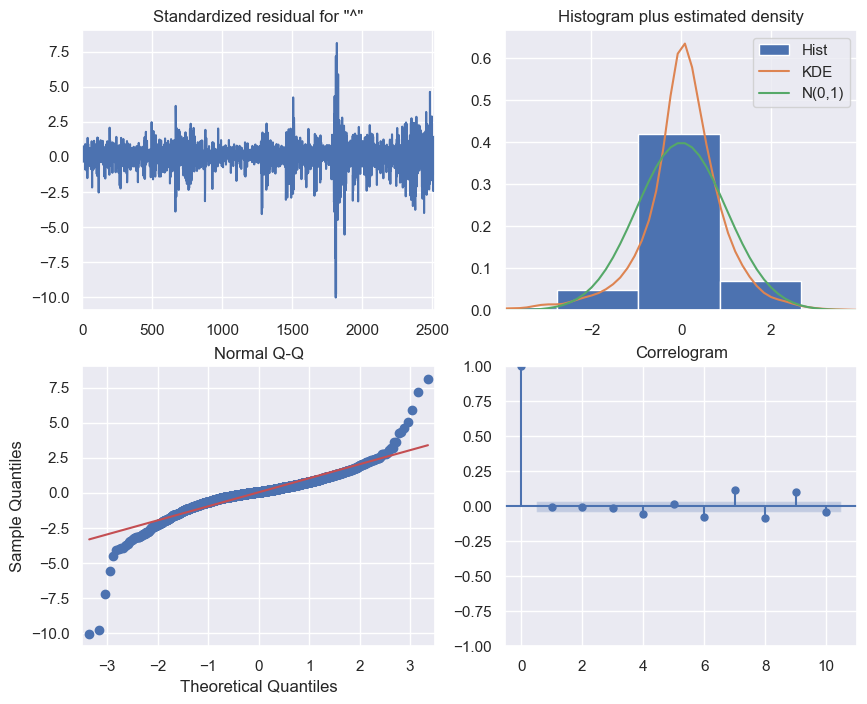

In [24]:
train.plot(title='Training Data')
best_model.plot_diagnostics(figsize=(10,8))
plt.show()

In [25]:
adf_test(ts_data, 'Original Series')
adf_test(np.log(ts_data), 'Log-Transformed Series')
adf_test(np.log(ts_data).diff(), 'Log-Differenced Series')

Augmented Dickey-Fuller Test: Original Series
ADF Statistic : -1.0312
p-value : 0.7417
# Lags Used : 10.0000
# Observations : 2507.0000
The series is non-stationary.
Augmented Dickey-Fuller Test: Log-Transformed Series
ADF Statistic : -1.4114
p-value : 0.5768
# Lags Used : 10.0000
# Observations : 2507.0000
The series is non-stationary.
Augmented Dickey-Fuller Test: Log-Differenced Series
ADF Statistic : -15.8374
p-value : 0.0000
# Lags Used : 9.0000
# Observations : 2507.0000
The series is stationary.


In [26]:
for d in [0, 1, 2]:
    try:
        model = ARIMA(np.log(ts_data), order=(1,d,1))
        fitted = model.fit()
        print(f'Order (1,{d},1) - AIC: {fitted.aic:.2f}')
    except Exception as e:
        print(f'Failed for d={d}: {e}')


Order (1,0,1) - AIC: -15539.03
Order (1,1,1) - AIC: -15557.61
Order (1,2,1) - AIC: -15539.47


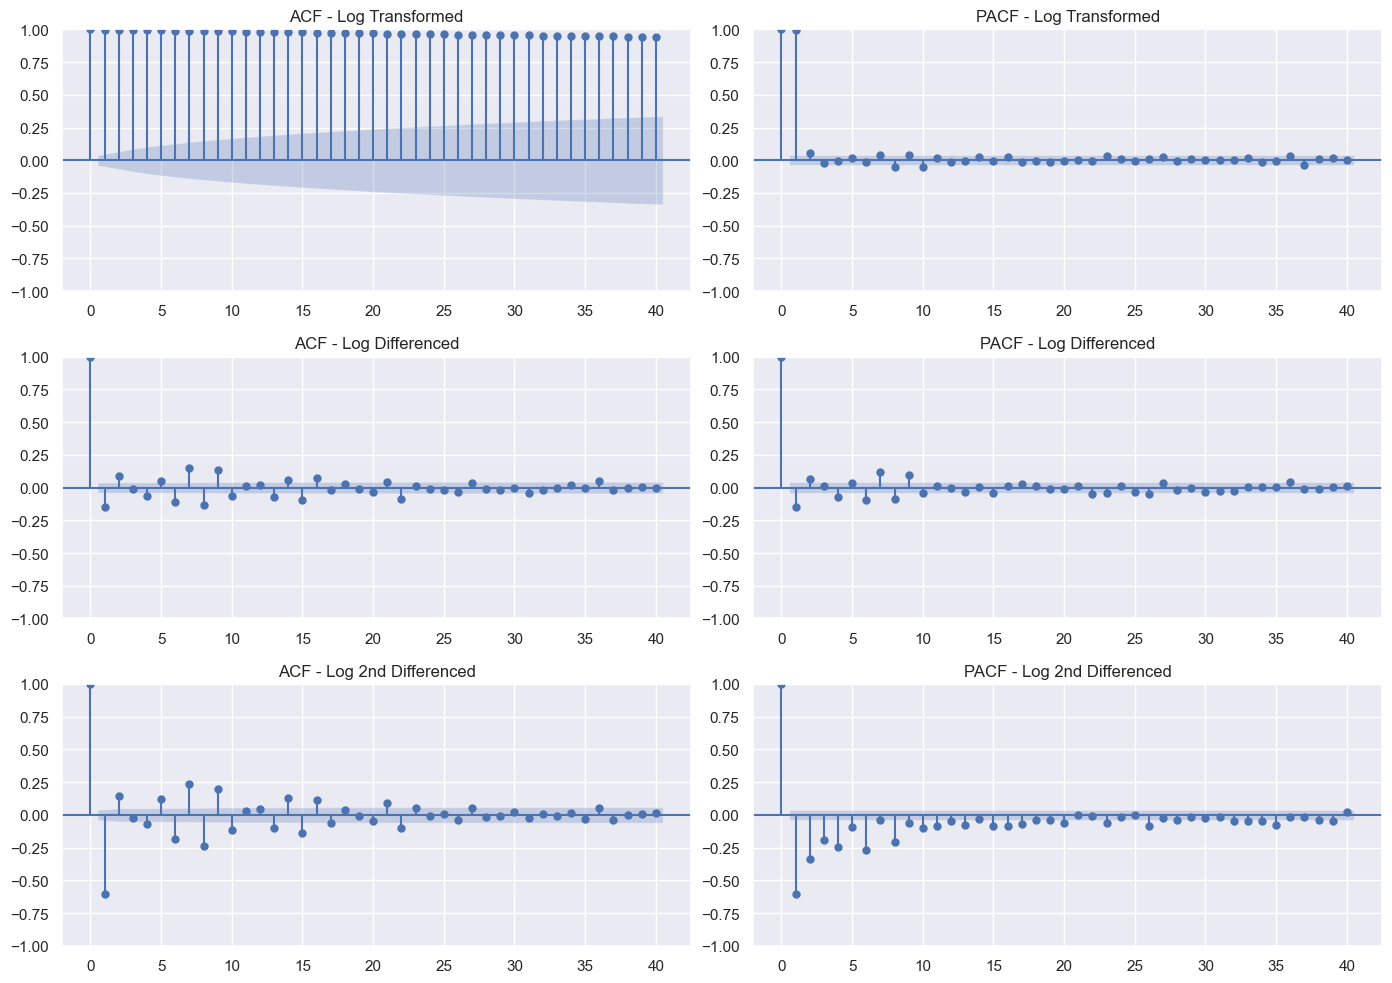

In [27]:
fig, axes = plt.subplots(3,2, figsize=(14,10))
plot_acf(np.log(ts_data).dropna(), lags=40, ax=axes[0,0])
axes[0,0].set_title('ACF - Log Transformed')

plot_pacf(np.log(ts_data).dropna(), lags=40, ax=axes[0,1])
axes[0,1].set_title('PACF - Log Transformed')

plot_acf(np.log(ts_data).diff().dropna(), lags=40, ax=axes[1,0])
axes[1,0].set_title('ACF - Log Differenced')

plot_pacf(np.log(ts_data).diff().dropna(), lags=40, ax=axes[1,1])
axes[1,1].set_title('PACF - Log Differenced')

plot_acf(np.log(ts_data).diff().diff().dropna(), lags=40, ax=axes[2,0])
axes[2,0].set_title('ACF - Log 2nd Differenced')

plot_pacf(np.log(ts_data).diff().diff().dropna(), lags=40, ax=axes[2,1])
axes[2,1].set_title('PACF - Log 2nd Differenced')

plt.tight_layout()
plt.show()

In [28]:
auto_model = pm.auto_arima(
    ts_log,
    start_p=0, max_p=5,
    start_q=0, max_q=5,
    d=None,           # Let auto_arima determine differencing
    seasonal=False,   
    trace=True,       # Prints progress
    error_action='ignore',  
    suppress_warnings=True,
    stepwise=True
)

print(auto_model.summary())

# Forecasting next 252 steps
n_forecast = 252
forecast, conf_int = auto_model.predict(n_periods=n_forecast, return_conf_int=True)

# Transform forecasts back if log-transformed
forecast_exp = np.exp(forecast)

print("Forecasted values:")
print(forecast_exp)

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-15503.774, Time=0.05 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-15555.786, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-15548.320, Time=0.21 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-15502.778, Time=0.02 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-15565.455, Time=0.11 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=-15563.650, Time=0.25 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-15563.272, Time=0.26 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-15559.505, Time=0.08 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=-15561.457, Time=0.16 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=-15563.948, Time=0.11 sec

Best model:  ARIMA(2,1,0)(0,0,0)[0] intercept
Total fit time: 1.302 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 2518
Model:               SARIMAX(2, 1, 0)   Lo

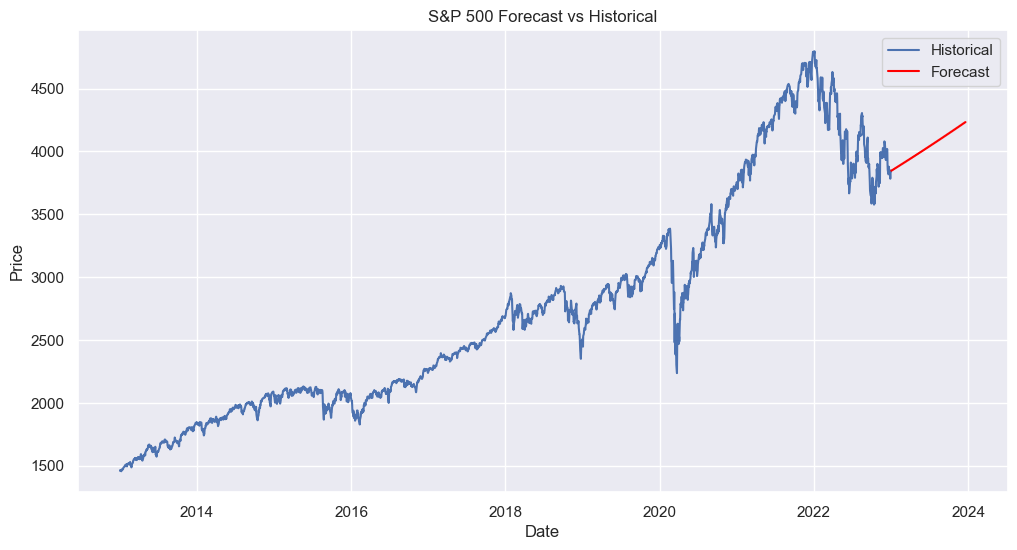

In [29]:
# Historical data (back to original scale)
historical = np.exp(ts_log)

# Forecast steps (already predicted)
forecast_steps = 252

# Generate forecast index
forecast_index = pd.date_range(start=sp500.index[-1] + pd.Timedelta(days=1), periods=forecast_steps, freq='B')  # Business days freq

# Plot historical + forecast
plt.figure(figsize=(12,6))
plt.plot(historical, label='Historical')
plt.plot(forecast_index, forecast_exp, color='red', label='Forecast')
plt.title('S&P 500 Forecast vs Historical')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.show()

In [31]:
"""

s_auto_model = pm.auto_arima(
    ts_log,
    start_p=0, max_p=2,
    start_q=0, max_q=2,
    d=None,           # Let auto_arima determine differencing
    seasonal=True,   
    start_P=0, max_P=2,    # Seasonal AR orders to search
    start_Q=0, max_Q=2,    # Seasonal MA orders to search
    m=252,
    trace=True,       # Prints progress
    error_action='ignore',  
    suppress_warnings=True,
    stepwise=True
)

print(s_auto_model.summary())

# Forecasting next 252 steps
n_forecast = 252
forecast, conf_int = s_auto_model.predict(n_periods=n_forecast, return_conf_int=True)

# Transform forecasts back if log-transformed
forecast_exp = np.exp(forecast)

print("Forecasted values:")
print(forecast_exp)

"""

'\n\ns_auto_model = pm.auto_arima(\n    ts_log,\n    start_p=0, max_p=2,\n    start_q=0, max_q=2,\n    d=None,           # Let auto_arima determine differencing\n    seasonal=True,   \n    m=252,\n    trace=True,       # Prints progress\n    error_action=\'ignore\',  \n    suppress_warnings=True,\n    stepwise=True\n)\n\nprint(s_auto_model.summary())\n\n# Forecasting next 252 steps\nn_forecast = 252\nforecast, conf_int = s_auto_model.predict(n_periods=n_forecast, return_conf_int=True)\n\n# Transform forecasts back if log-transformed\nforecast_exp = np.exp(forecast)\n\nprint("Forecasted values:")\nprint(forecast_exp)\n\n'

Couldnt run this SARIMA model, took too long and timed out. Just try the ARIMA orders with seasonality

In [32]:
sa_model = SARIMAX(ts_log, order=(2,1,0), seasonal_order=(1, 0, 1, 252), enforce_stationarity=False, enforce_invertibility=False)
sa_model_fit = sa_model.fit()

# Summary
print(sa_model_fit.summary())

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -2.74898D+00    |proj g|=  5.43691D+00


 This problem is unconstrained.



At iterate    5    f= -2.74996D+00    |proj g|=  7.06878D-03

At iterate   10    f= -2.74996D+00    |proj g|=  2.39084D-01

At iterate   15    f= -2.74999D+00    |proj g|=  3.67259D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     18     25      1     0     0   7.615D-03  -2.750D+00
  F =  -2.7499893774885393     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
                                       SARIMAX Results                                       
Dep. Variable:                                 ^GSPC   No. Observations:                 2518
Model:             SARIMAX(2, 1, 0)x(1, 0, [1], 2

<Figure size 1400x500 with 0 Axes>

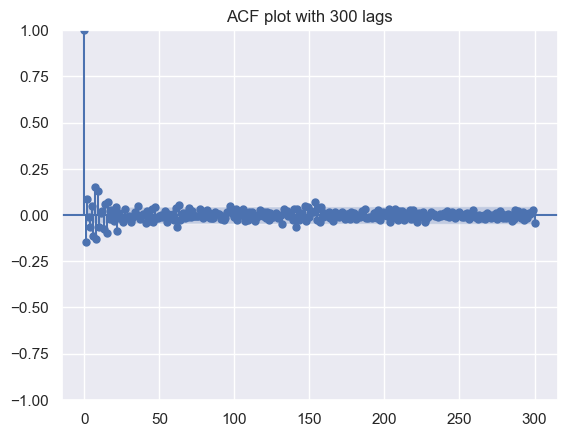

<Figure size 1400x500 with 0 Axes>

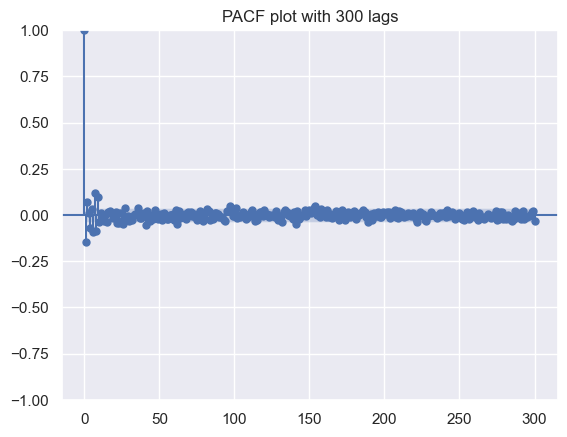

In [33]:
plt.figure(figsize=(14,5))
plot_acf(ts_log_diff, lags=300)
plt.title('ACF plot with 300 lags')
plt.show()

plt.figure(figsize=(14,5))
plot_pacf(ts_log_diff, lags=300)
plt.title('PACF plot with 300 lags')
plt.show()

No spikes, still no seasonality

auto_model with ARIMA(2,1,0) was best.

The forecast accuracy in this test predicts the general trend of the S&P500, which grows steadily over time. The model did not pick up on the dip from COVID in the sense that this was smoothed over, but it likely effected the slope of predicted increase by lowering it. In essence, the model gives a solid general expectation of S&P growth over the 10 years but cannot account for circumstances short term that may lead to sudden jumps or dips.